In [19]:
import warnings
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_diabetes, fetch_openml,load_iris,fetch_california_housing
from sklearn.feature_selection import mutual_info_regression, f_regression, RFE, SelectFromModel, SelectKBest, f_classif
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import (
RepeatedStratifiedKFold, 
cross_val_score, 
train_test_split, 
GridSearchCV,
cross_val_predict, 
learning_curve, 
validation_curve)
from tqdm.auto import tqdm
from sklearn.linear_model import LinearRegression,Lasso
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_absolute_error,zero_one_loss
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, classification_report, mean_squared_error
from sklearn.neighbors import KNeighborsClassifier
from mlxtend.evaluate import bias_variance_decomp
#sharper plots
%config InlineBackend.figure_format = 'retina'

from sklearn.linear_model import (LogisticRegression, LogisticRegressionCV,
                                  SGDClassifier)

warnings.filterwarnings("ignore")

In [ ]:
data_path = "D:/data/machine_learning/" 

In [2]:
def plot_with_err(params,fun_cv, label):
    mus = np.mean(fun_cv, axis=-1)
    stds = np.std(fun_cv, axis=-1)
    plt.plot(params, mus, label=label)
    plt.fill_between(params, mus - stds, mus + stds, alpha=0.2)
    #plt.fill_between(params, mus - 2*test_acc.std(axis=1), test_acc.mean(axis=1) + 2*test_acc.std(axis=1), color='#888888', alpha=0.2)
    # plt.errorbar(params, mus, stds, linestyle='None', marker='^', label=label)

Мы уже знаем, что среднеквадратичный риск на фиксированной выборке X можно расписать как 
$$E = Var(h) + Bias^2(h) + Noise(y)$$
Здесь $Bias^2(h) = E_x[(\overline{h}(X) - \overline{y}(X))^2]$ показывает, насколько средняя модель отклонится от матожидания таргета (идеальной модели). 
$Var(h) = E_{x,D}[(h(X, D) - \overline{h}(X))^2]$ - показывает разброс обученных моделей относительно среднего ответа. 
$Noise(y) = E_{x,y}[(\overline{y}(X) - Y)^2]$ - дисперсия самого таргета при фиксированном x. Это неустранимая ошибка, которой соответствует самый идеальный прогноз.

Смещение показывает, насколько хорошо можно с помощью данного семейства моделей приблизиться к оптимальной модели. Как правило, оно маленькое у сложных семейств и большое у относительно простых. Вопрос: Назовите такие семейства.

Дисперсия показывает, насколько будет изменяться предсказание в зависимости от выборки - то есть насколько ваше семейство склонно к переобучению. 


Построим для иллюстрации простой пример и проверим, соответствует ли утверждение, что при увеличении сложности модели уменьшится смещение. Также проверим, растет ли при увеличении сложности модели дисперсия. Для начала посмотрим на простую зависимость, довольно сильно зашумленную.

In [3]:
def f(x):
    return 2.5 * np.cos(1.5 * x)*x  + 1 * x
    
def generate_data(n_samples: int = 50, noise: float = 3, n_noise_samples: int = 1):
    x = np.random.rand(n_samples) * 20 - 10
    x = np.sort(x)

    y = np.zeros((n_samples, n_noise_samples))
    for i in range(n_noise_samples):
        y[:, i] = f(x) + np.random.normal(0.0, noise, n_samples)
    return x.reshape((n_samples, 1)), y.squeeze()

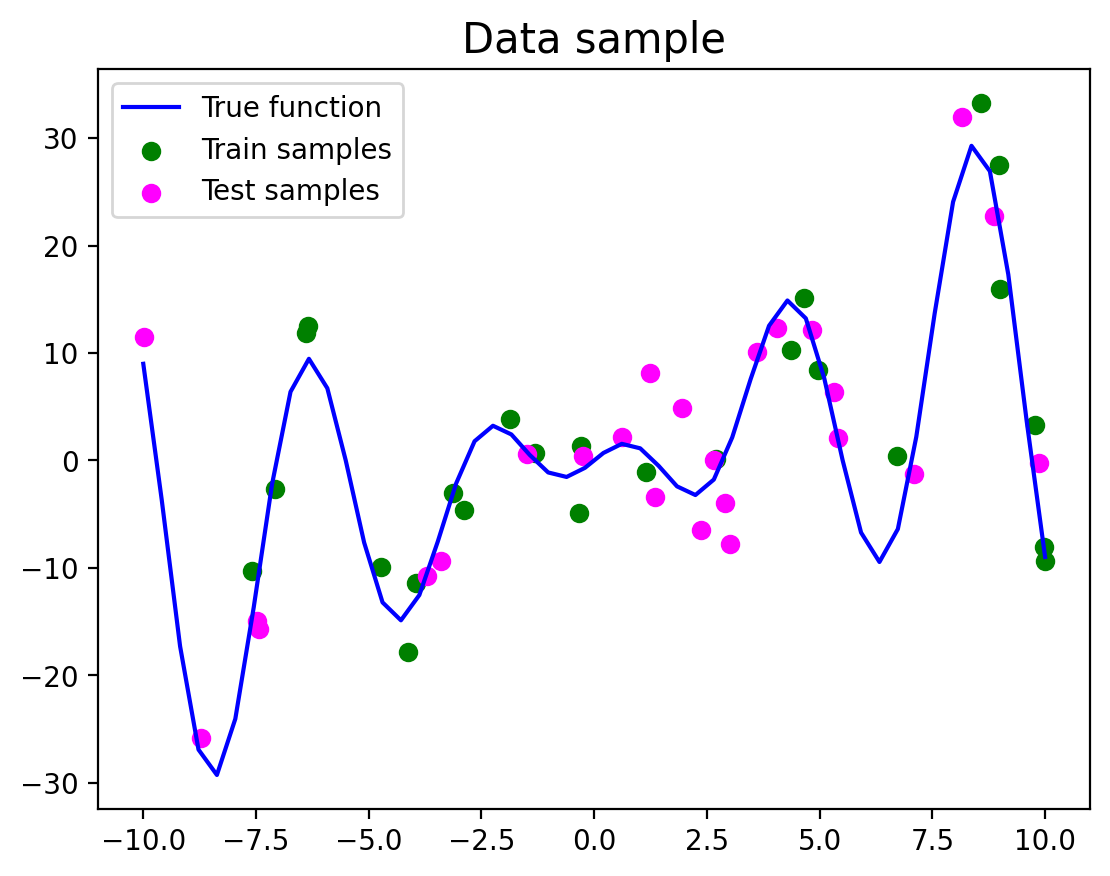

In [4]:

x_ticks = np.linspace(-10, 10)
X, y = generate_data(noise=4)
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

plt.title('Data sample', fontsize=15)
plt.plot(x_ticks, f(x_ticks), color="blue", label="True function")
plt.scatter(x_train, y_train, color="green", label="Train samples")
plt.scatter(x_test, y_test, color="magenta", label="Test samples")
plt.legend()
plt.show()

Теперь мы можем сгенерировать датасеты и попробовать обучать модели на них:

In [5]:
def train_on_subset(model_class, parameters, n_train_samples: int = 20, noise: float = 3):
    x_train, y_train = generate_data(n_samples=n_train_samples, noise=noise)
    model = model_class(**parameters)
    model.fit(x_train, y_train)
    return model, x_train, y_train

Для начала посмотрим, как вообще будет выглядеть предсказание в зависимости от глубины дерева. 

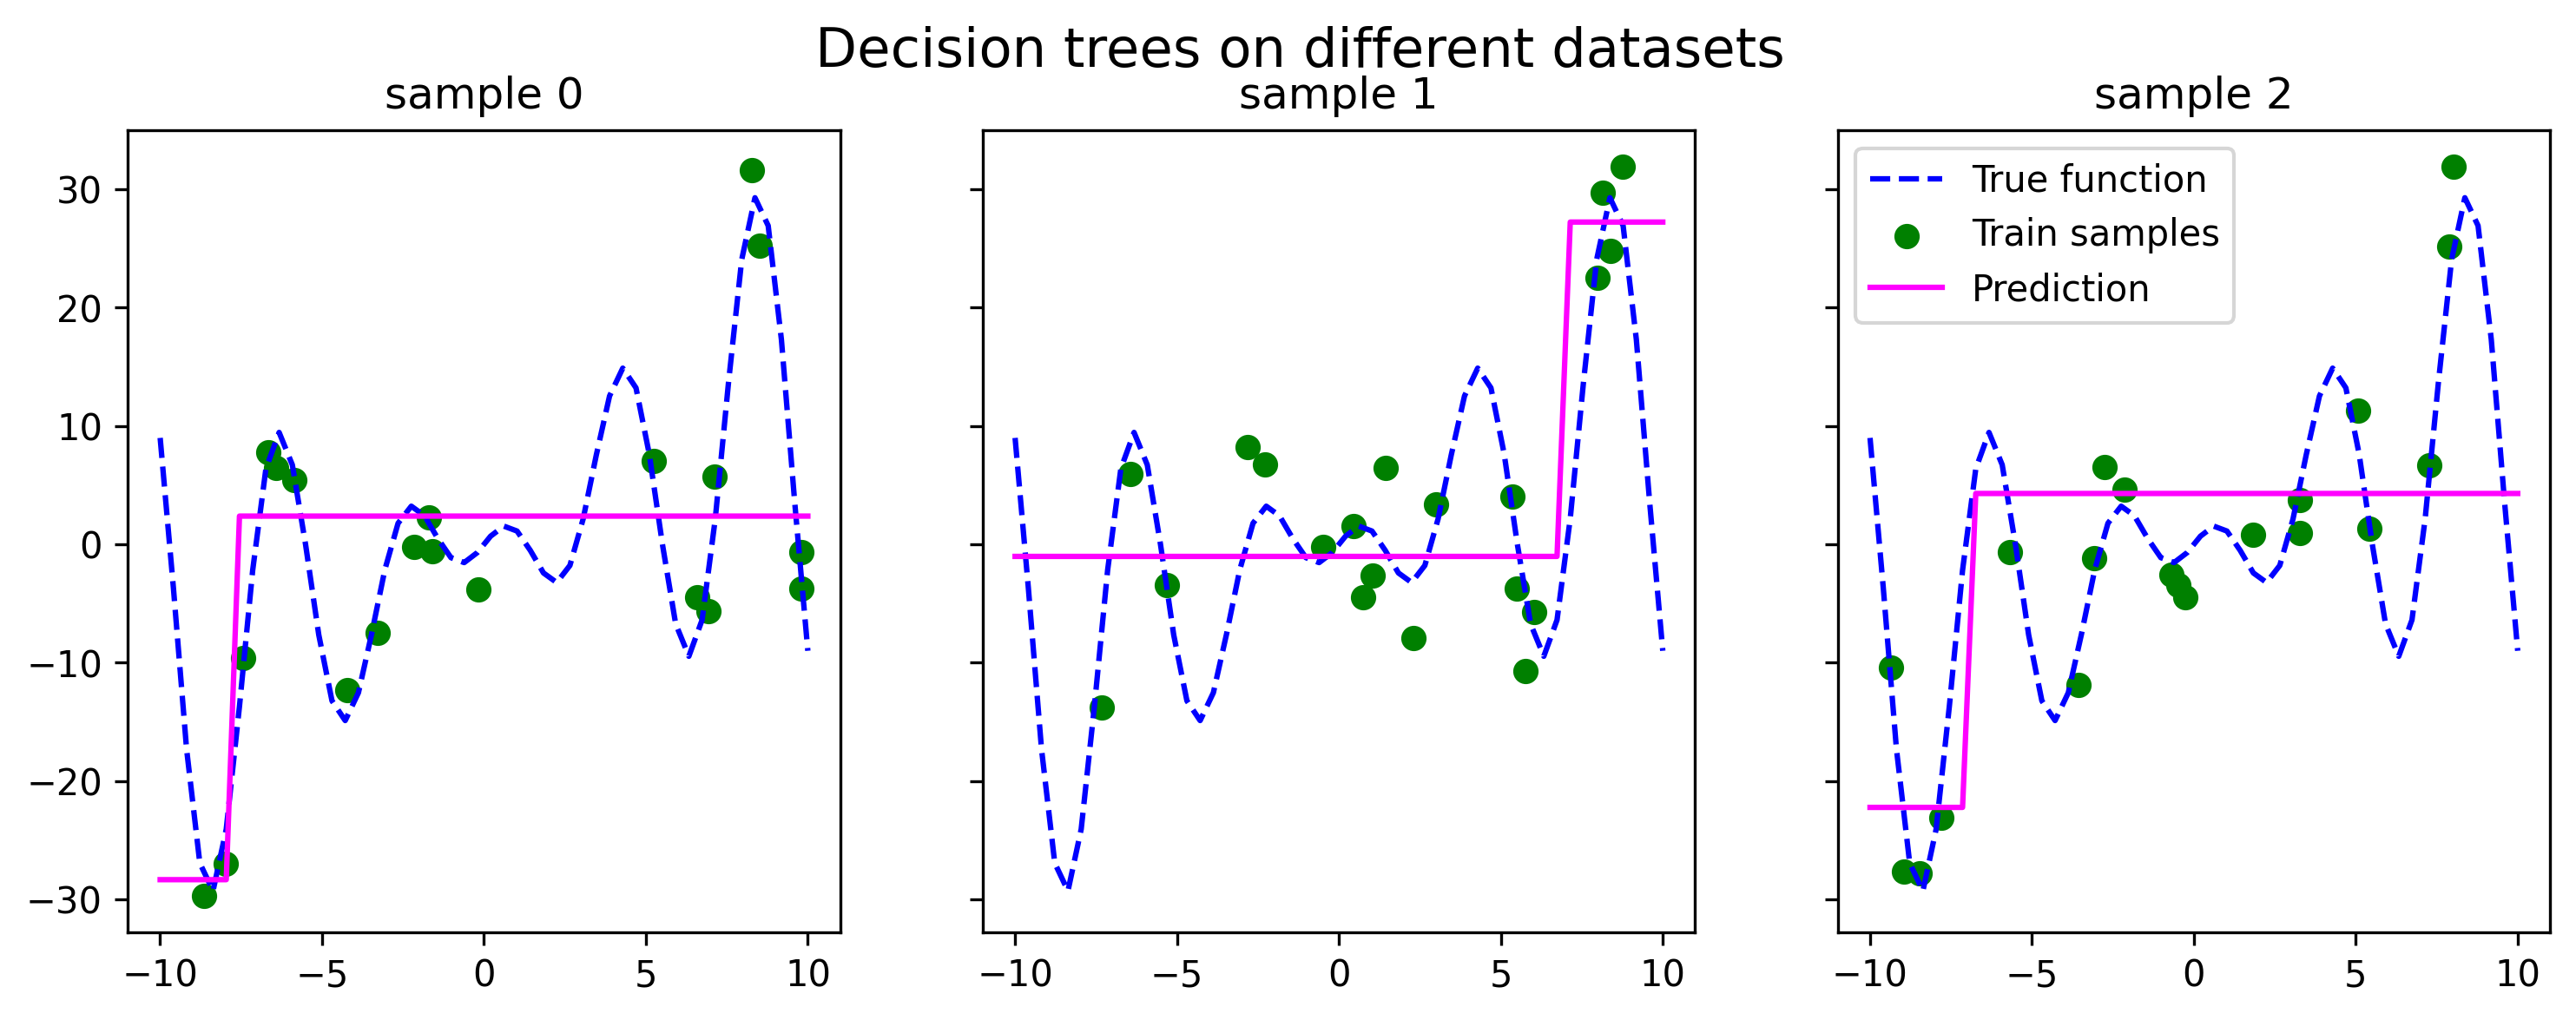

In [6]:
parameters = {"max_depth": 1}
np.random.seed(1243)

fig, ax = plt.subplots(1, 3, figsize=(12,4), dpi=150, sharey=True)
fig.suptitle("Decision trees on different datasets", fontsize=15)
for i in range(3):
    model, x_train, y_train = train_on_subset(model_class=DecisionTreeRegressor, parameters=parameters, noise=3)
    preds = model.predict(x_ticks[:, None])
    ax[i].plot(x_ticks, f(x_ticks), color="blue", label="True function", linestyle="--")
    ax[i].scatter(x_train, y_train, color="green", label="Train samples")
    ax[i].plot(x_ticks, preds, color="magenta", label="Prediction")
    ax[i].set_title(f"sample {i}")
plt.legend()

**Задание:** Постройте графики для большей глубины. 

Теперь мы можем получить оценки ошибки и ее составляющих. Для этого насемплируем 1000 выборок, предварительно выделив общий тест сет, и вычислим test MSE для каждой из выборок.

**Задание:** Дополните код

In [20]:
def get_predictions(
    model_cards,
    n_repeats: int, noise: float, n_train_samples: int, 
    n_test_samples: int, n_noise_samples: int):
  
    x_test, y_test = generate_data(n_samples=n_test_samples, 
                                 n_noise_samples=n_noise_samples, noise=noise)
    predictions = {} # to avoid creation of [] 
    results = []
    
    for i, (model_class, parameters) in enumerate(model_cards):
        np.random.seed(12341)
        predictions[i] = [] 
        for j in tqdm(range(n_repeats), desc=f"{model_class.__name__}, {parameters}"):
            # Generate new training data for each repeat
            x_train, y_train = generate_data(n_samples=n_train_samples,
                                           n_noise_samples=n_noise_samples,
                                           noise=noise)
            
            # Create and train the model
            model = model_class(**parameters)
            model.fit(x_train, y_train)
            
            # Get predictions on test data and store them
            y_pred = model.predict(x_test)
            predictions[i].append(y_pred)
            
        results.append({
          "name": model_class.__name__,
          "parameters": parameters,
          "predictions": np.stack(predictions[i]),
          "x_test": x_test,
          "y_test": y_test
        })
    return results

In [16]:
!jupyter nbextension enable --py widgetsnbextension

usage: jupyter [-h] [--version] [--config-dir] [--data-dir] [--runtime-dir]
               [--paths] [--json] [--debug]
               [subcommand]

Jupyter: Interactive Computing

positional arguments:
  subcommand     the subcommand to launch

options:
  -h, --help     show this help message and exit
  --version      show the versions of core jupyter packages and exit
  --config-dir   show Jupyter config dir
  --data-dir     show Jupyter data dir
  --runtime-dir  show Jupyter runtime dir
  --paths        show all Jupyter paths. Add --json for machine-readable
                 format.
  --json         output paths as machine-readable json
  --debug        output debug information about paths

Available subcommands: console dejavu events execute kernel kernelspec lab
labextension labhub migrate nbconvert notebook run server troubleshoot trust

Jupyter command `jupyter-nbextension` not found.


In [ ]:
models = [[DecisionTreeRegressor, {"max_depth": depth}] for depth in range(1, 16)]

results = get_predictions(
    models,
    n_repeats=1000, 
    n_test_samples=500, 
    n_train_samples=500,
    n_noise_samples=300,
    noise=3
)

DecisionTreeRegressor, {'max_depth': 1}:   0%|          | 0/1000 [00:00<?, ?it/s]

DecisionTreeRegressor, {'max_depth': 10}: 100%|██████████| 1000/1000 [00:17<00:00, 56.98it/s]


**Задание**: Посчитайте размеры массивов предсказаний, x_test, y_test.

In [ ]:
print(f"predictions shape: n_repeats x n_test_samples = {results[0]['predictions'].shape}")
print(f"x_test shape: n_test_samples x 1 = {results[0]['x_test'].shape}")
print(f"y_test shape: n_test_samples x n_noise_samples = {results[0]['y_test'].shape}")

**Задание**: Дополните код, вычисляющий bias, variance, noise

In [8]:
def get_bias_variance(results) -> pd.DataFrame:
    records = []
    for res in results:
        x_test, y_test = res["x_test"], res["y_test"]
        predictions = res["predictions"]
        bias = # calculate bias
        variance = # calculate variance
        noise = # calculate noise
        error = (predictions[..., None] - y_test[None]) ** 2

        records.append({
            "name": res["name"],
            "parameters": res["parameters"],
            "bias_sq": np.mean(bias ** 2),
            "variance": np.mean(variance),
            "noise": np.mean(noise),
            "mse": np.mean(error),
            "error_decomposed": np.mean(bias ** 2 + variance + noise)
        })
    
    return pd.DataFrame.from_records(records)

SyntaxError: invalid syntax (2757285999.py, line 6)

In [ ]:
bias_variance_trees = get_bias_variance(results)
bias_variance_trees.head()

Теперь мы можем построить график разложения!

In [ ]:
def plot_bias_variance(
    bias_variance_results: pd.DataFrame, 
    parameter_name: str,  
    parameter_values: list[float]
) -> None:
    plt.figure(figsize=(8, 5), dpi=150)
    plt.xticks(parameter_values)
    plt.plot(parameter_values, bias_variance_results.bias_sq, label="bias", color="blue")
    plt.plot(parameter_values, bias_variance_results.variance, label="variance", color="orange")
    plt.plot(parameter_values, bias_variance_results.noise, label="noise", color="green")
    plt.plot(parameter_values, bias_variance_results.mse, label="MSE", color="magenta")
    plt.xlabel(parameter_name)
    plt.legend(fontsize=10, loc="upper right")
    plt.show()

In [ ]:
depth = bias_variance_trees.apply(lambda r: r.parameters["max_depth"], axis=1)

plot_bias_variance(bias_variance_trees, parameter_name="Tree depth",  parameter_values=depth)


Видно, что при увеличении глубины деревьев смещение падает практически до нуля, а разброс нарастает. Проверим, будет ли это сохраняться и дальше:

In [ ]:

models = [[DecisionTreeRegressor, {"max_depth": depth}] for depth in range(1, 26)]

results = get_predictions(
    models,
    n_repeats=1000, 
    n_test_samples=500, 
    n_train_samples=500,
    n_noise_samples=300,
    noise=3
)
bias_variance_many_trees = get_bias_variance(results)
plot_bias_variance(
    bias_variance_many_trees, 
    parameter_name="Tree depth",  
    parameter_values=bias_variance_many_trees.apply(lambda r: r.parameters["max_depth"], axis=1)
)
 

Вопрос: Почему с большой глубиной дерева значения ошибки и разложения перестают меняться? 

**Задание**: Постройте зависимости для других сочетаний таргета и шума.

**Задание**: Постройте графики предсказаний всех 1000 деревьев на одном графике (и таргета тоже)

Перейдем к реальному примеру. Для таких данных, конечно, тоже можно посчитать, как раскладывается ошибка.

Рассмотрим разделение ошибки на примере данных о продаже зданий в Калифорнии. Разложение для некоторых функций, в том числе, для mse, поддерживается библиотекой mlextend. Сейчас попробуем ответить на два вопроса: действительно ли в реальной жизни ошибка подчиняется этому свойству и как изменение модели повлияет на разложение.

In [ ]:
data = fetch_california_housing()

X = data.data
y = data.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)
# Model definition
model = LinearRegression()
# Estimation of bias and variance using bias_variance_decomp
#Note here we are using loss as 'mse' and setting default bootstrap num_rounds to 200
mse, bias, var = bias_variance_decomp(
    model, X_train, y_train, X_test, y_test, loss='mse', num_rounds=200, random_seed=123
    )
y_pred=model.predict(X_test)
# summarize results
print('MSE from bias_variance lib [avg expected loss]: %.3f' % mse)
print('Avg Bias: %.3f' % bias)
print('Avg Variance: %.3f' % var)
print('Mean Square error by Sckit-learn lib: %.3f' % mean_squared_error(y_test,y_pred))

**Задание(*):** Реализуйте кастомную функцию для bias-variance-decomp, сравните с версией из mlxtend

В результате наших расчетов из приведенного выше очевидно, что общая ошибка = смещение + дисперсия, мы также могли видеть, что MSE, рассчитанная на основе библиотеки sckit, почти равна той, что мы получили их mlextend.

In [ ]:
lasso_model = Lasso(alpha=0.05)
error_reg_las, bias_reg_las, var_reg_las = bias_variance_decomp(
    lasso_model, X_train, y_train, X_test, y_test, loss='mse', random_seed=123
    )

y_pred=lasso_model.predict(X_test)
print('MSE from bias_variance lib [avg expected loss]: %.3f' % error_reg_las)
print('Avg Bias: %.3f' % bias_reg_las)
print('Avg Variance: %.3f' % var_reg_las)
print('Mean Square error by Sckit-learn lib: %.3f' % mean_squared_error(y_test,y_pred))

Можно заметить, что после регуляризации смещение увеличелось, дисперсия немного уменьшилась, а общая средняя ошибка также снизилась.

**Задание:** Постройте график разложения для разных уровней регуляризации. При каком уровне регуляризации ошибка начинает увеличиваться из-за смещения?

Как же измеряются Bias и Variance? Конечно, мы не можем оценить bias и variance без доступа ко всем возможным выборкам, но можем приблизиться к решению задачи как можно ближе. Это можно сделать с помощью бутстрапирования выборки.

Бутстрап работает на удивление просто.
Предположим, что наша выборка D размера n на представляет генеральную совокупность. После этого мы можем сгененрировать эмпирическое распределение необходимой статистики, выбирая с замещением $N >> 100$ подвыборок объема n из этой совокупности (назовем псевдовыборками), и рассчитывая для них нужную статистику. 

![calib_1](../additional_materials/images/bootstrap.png)
Вообще, этот метод очень хорош для получения интервальных оценок, стандартных отклонений и прочего, даже если не задавать ограничения на распределения. 

Обратите внимание:
1) Чтобы оценка была несмещённой, необходимо генерировать выборки такого же размера, как и размер исходной выборки;
2) Количество итераций бутстрепа рекомендуется брать в диапазоне от 1000 до 10000. Этого, как правило, хватает для получения достаточно точных результатов.

Если бутстрап такой замечательный, то почему его не используют во всех задачах? Основной недостаток – его скорость работы. Для больших объемов данных вычисления могут требовать знчительных временных затрат. Во вторых, если в данных присутвтуют зависимости (выборки получаются не iid), то оценка не будет приближать исходное распределение. Так что разные особенности данных тоже надо учитывать. И последнее - если исходная выборка нерепрезентативна, то и результат будет не очень.

Вопрос: какие применения бутстрапа вы знаете?

Вопрос: как бутстрапом получить bias и variance? 

**Задание(*)**: Реализуйте функцию для вычисления смещения и дисперсии с помощью бутстрепа для MSE.

# Классификация

Существуют обобщения разложения. Последуем нотации из статьи В общем случае "главные" предсказания - это значения, которые отличаются наименее (по отношению к функции потерь $L$) от всех меток в Y: $y_{main} = argmin_{\hat{y}}(E(L(y, \hat y))$. В случае MSE это среднее, MAE - медиана. Для 0-1 лосса это мода. 
Тогда Bias и Variance можно определить как: Bias - это потери среднего предсказания по отношению к главному: $L(y, y_{main})$. Var - Средние потери предсказаний относительно среднего: $E(L(\hat{y}, y_{main})$. 
Тогда в общем случае разложение будет выглядеть как: 
$$E = с_1Var(h) + Bias(h) + с_2Noise(y),$$
где $с_1, c_2$ - константы, зависящие от лосса [[источник](https://homes.cs.washington.edu/~pedrod/papers/mlc00a.pdf)].

Рассмотрим 0–1 loss:

$$
\mathcal{L}_{01}(\hat{y}, y) = \frac{1}{n}\sum_{i=1}^n \delta_{\hat{y_i} \neq y_i} \quad \text{with} \quad \delta_{\hat{y_i} = y_i} = 
\begin{cases} 
0, & \text{if } \hat{y_i} \neq y_{main} \\
1, & \text{otherwise}
\end{cases}
$$

Этот лосс не что иное как error rate. Он очень простой, но при этом не используется на практике. Вопрос: почему?

Смещение и дисперсия для потерь 0–1 следующие. 

Смещение равно 1, если основной прогноз не согласуется с истинной меткой y, и 0 в противном случае:
$$bias_i =  \begin{cases} 
1, & y ≠ y_{main} \\
0, & \text{otherwise}
\end{cases}$$

Усреднение даст финальный ожидаемый $Bias$.

Теперь к дисперсии. В случае 0-1 $L(y, \hat y)= P(y \neq \hat y) = Bias + Var$.

Рассмотрим случай, когда Bias=0. Тогда $Loss = Var$.
Тогда, если подставить  $\mathcal{L}_{01}$ в формулы для обобщенного лосса, мы получим, что дисперсия определяется как вероятность того, что предсказанная метка не соответствует главному предсказанию:
$Var = P(\hat y \neq E[\hat y]) = P(\hat y \neq y_{main}])$

Теперь более сложный случай - когда Bias = 1. 
Тогда $L(y, \hat y)= P(y \neq \hat y) = 1 - P(y = \hat y)$. Т.к. мы рассматриваем случай $\hat{y} \neq y_{main}$. то получаем, что  $\hat y \neq y_{main}$, и выражение для лосса можно переписать как $L(y, \hat y)=  1 - P(y \neq y_{main}) = Bias - Var$. 

Получается, что увеличение Var может улучшить нашу модель! Неинтуитивно. 
Вопрос: ПОчему увеличение Var может помочь?

В качестве примера рассмотрим датасет rice classification. Этот датасет посвящен классификации риса. 

In [ ]:
data = pd.read_csv(data_path + "wdbc/data.csv")
data = data.drop(['id', 'Unnamed: 32'], axis=1)
data['diagnosis'] = data['diagnosis'].replace({'B': 0, 'M': 1}).astype(int)
y = data["diagnosis"].astype("int").values
X = data.drop("diagnosis", axis=1).values

## Деревья решений

In [ ]:
degree = 2
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3,
                                                    random_state=123,
                                                    shuffle=True,
                                                    stratify=y)

In [ ]:
pipeline = Pipeline(
        [
            ("poly", PolynomialFeatures(degree=degree)),
            (
                "tree",
                DecisionTreeClassifier(random_state=123, max_depth=6),
            ),
        ]
    )
clf_dt = DecisionTreeClassifier(random_state=123)
#clf_dt.fit(X_train,y_train)
clf_dt.fit(X_train, y_train)
y_pred=clf_dt.predict(X_test)

avg_expected_loss, avg_bias, avg_var = bias_variance_decomp(
        clf_dt, X_train, y_train, X_test, y_test,
        loss='0-1_loss',
        random_seed=123)

print('Average expected loss: %.3f' % avg_expected_loss)
print('Average bias: %.3f' % avg_bias)
print('Average variance: %.3f' % avg_var)
print('Sklearn 0-1 loss: %.3f' % zero_one_loss(y_test,y_pred))
print('Sklearn accuracy: %.3f' % clf_dt.score(X_test, y_test))

Запруним наше дерево, уменьшив его сложность. 

In [ ]:
#Prune tree

Теперь мы можем и посмотреть, как меняются составляющие с усложнениесм дерева.

In [ ]:
bias, var, error= [], [], []
max_d = 10
for d in range(1,max_d):
    # collect b,v,e
#plot resulting curves

plt.xlabel('Algorithm Complexity(depth)')
plt.ylabel('Error')
plt.legend()

Мы можем рассмотреть и увеличение степени полинома. Но это может быть очень долго!

In [ ]:
bias, var, error= [], [], []
max_d = 4
for d in range(1, max_d):
        # collect b,v,e
#plot resulting curves

plt.xlabel('Algorithm Complexity(degree of polynomial)')
plt.ylabel('Error')
plt.legend()

Выше мы видим, что общиая ожидаемая ошибка = сумма смещения + дисперсии и прунинг имеет некоторый эффект на уменьшение дисперсии. Мы также видим момент переобучения - когда bias доходит до нуля, а variance начинает повышаться.

Случайный лес, в том числе за счет бутстрапа, позволяет уменьшить ожидаемую ошибку. В его основе композиция деревьев, обученных на случайных подвыборках с помощью беггинга, при этом при каждом разбиении случайно выбирается подмножество из всех признаков. 
При беггинге (Bootstrap Aggregating) многочисленные повторы исходного набора данных создаются с использованием случайного выбора с заменой. Каждый производный набор данных затем используется для построения новой модели, и модели собираются в ансамбль. Чтобы сделать прогноз, все модели в ансамбле опрашиваются и их результаты усредняются.

В целом, беггинг (bootstrap aggregation) не увеличивает смещенеие модели, но при этом *всегда* уменьшает дисперсию. Интересно: В идеальном случае для MSE, обучение N нескоррелированных алгоритмов с помощью бутстрапа уменьшает ошибку в N раз! 

В своём блоге Лео Бриман (Leo Breiman), создатель случайного леса, написал следующее:
 > Random forest does not overfit. You can run as many trees as you want.

Это относилось только к числу деревьев. В целом, мы можем ожидать, что дисперсия перестанет расти в какой-то момент. 
Проверим, так ли это. 

**Задание**: Выведите отношение ожидаемой ошибки к ошибке одной модели в случае усреднения N моделей для MSE.

In [ ]:
#clf_RF = RandomForestClassifier(max_depth=4, random_state=0)
#clf_RF.fit(X_train,y_train)

pipeline = Pipeline(
        [
            ("poly", PolynomialFeatures(degree=degree)),
            (
                "tree",
                RandomForestClassifier(max_depth=5, random_state=0),
            ),
        ]
    )
pipeline.fit(X_train, y_train)
y_pred=pipeline.predict(X_test)
avg_expected_loss, avg_bias, avg_var = bias_variance_decomp(
        pipeline, X_train, y_train, X_test, y_test,
        loss='0-1_loss',
        random_seed=123)

print('Average expected loss: %.3f' % avg_expected_loss)
print('Average bias: %.3f' % avg_bias)
print('Average variance: %.3f' % avg_var)
print('Sklearn 0-1 loss: %.3f' % zero_one_loss(y_test,y_pred))

**Задание**: Постройте графики зависимости от глубины дерева для фиксированной степени полинома.

In [ ]:
bias, var, error= [], [], []
max_d = 10
# Your code
plt.xlabel('Algorithm Complexity(depth)')
plt.ylabel('Error')
plt.legend()

**Задание**: Постройте графики зависимости от числа деревьев для фиксированной степени полинома.

**Задание(*):** Постройте графики зависимости от числа деревьев, использующих только k случайных фичей, где k корень от числа всех фичей, для фиксированной степени полинома.


In [ ]:
bias, var, error= [], [], []
# Your code
plt.xlabel('Algorithm Complexity(n_trees)')
plt.ylabel('Error')
plt.legend()

 На практике единственным ограничением размера леса является время вычислений, поскольку можно обучить бесконечное количество деревьев без увеличения систематической ошибки и с постоянным (хотя и асимптотически уменьшающимся) уменьшением дисперсии.


## KNN

Давайте также попробуем заглянуть в KNN.

Обычно модель KNN с низкими значениями k имеет высокую дисперсию и низкое смещение, но по мере увеличения k дисперсия уменьшается, а смещение увеличивается.


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
clf_knn = KNeighborsClassifier(n_neighbors=3)
clf_knn.fit(X_train,y_train)
y_pred=clf_knn.predict(X_test)


avg_expected_loss, avg_bias, avg_var = bias_variance_decomp(
        clf_knn, X_train, y_train, X_test, y_test,
        loss='0-1_loss',
        random_seed=123)

print('Average expected loss: %.3f' % avg_expected_loss)
print('Average bias: %.3f' % avg_bias)
print('Average variance: %.3f' % avg_var)
print('Sklearn 0-1 loss: %.3f' % zero_one_loss(y_test,y_pred))

Можно заметить, что смещение относительно велико [для k=3] по сравнению с дисперсией. И ожидаемые  ошибки больше, чем у модели RF.

In [ ]:
ks = [i for i in range(1,21)]
model = KNeighborsClassifier()

val_curve_train, val_curve_test = validation_curve(
    estimator=model,
    X=X,
    y=y,
    param_name="n_neighbors",
    param_range=ks,
    cv=5,
    scoring="accuracy"
)

In [ ]:
plot_with_err(ks, val_curve_train, label="training scores")
plot_with_err(ks, val_curve_test, label="validation scores")
plt.xlabel(r"$\k$")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

**Задание:** Постройте validation curves для деревьев и случайного леса.

Для различных значений k в kNN давайте также рассмотрим, какими будут наши ошибки, смещение и дисперсии.

In [ ]:
bias_KnnClass, var_KnnClass,error_KnnClass, = [], [], []
for k in range(1,21):
    clf_knn = # your code
    avg_expected_loss, avg_bias, avg_var = bias_variance_decomp(clf_knn, X_train, y_train, X_test, y_test, loss='0-1_loss', random_seed=123)
    bias_KnnClass.append(avg_bias)
    var_KnnClass.append(avg_var)
    error_KnnClass.append(avg_expected_loss)
plt.plot(range(1,21), error_KnnClass, 'red', label = 'total_error',linestyle='dashed')
plt.plot(range(1,21), bias_KnnClass, 'brown', label = 'bias^2')
plt.plot(range(1,21), var_KnnClass, 'yellow', label = 'variance')
plt.xlabel('Algorithm Complexity(K)')
plt.ylabel('Error')
plt.legend()

Как и ожидалось, при увеличении k уменьшается дисперсия и немного увеличивается смещение. 


**Задание**: Постройте графики зависимости bias-variance от сложности для регрессии


**Задание**: Постройте графики validation_curve от сложности для регрессии. Какая точка, по вашему мнению, соответствует наилучшему набору параметров?
